# Task 2

In [56]:
# Task 2.1


KNN results  (Acc: 38.89%)
              precision    recall  f1-score   support

           0      0.393     0.846     0.537        13
           1      0.333     0.200     0.250        10
           2      0.500     0.077     0.133        13

    accuracy                          0.389        36
   macro avg      0.409     0.374     0.307        36
weighted avg      0.415     0.389     0.311        36

Macro-F1:    0.307

	Replicate: 1/10
		Iter	Loss			Rel. loss
		1000	0.25310197	0.002680869
		2000	0.023141986	0.0018439472
		3000	0.0055060047	0.0011379912
		4000	0.0020506803	0.00087076065
		5000	0.0009193449	0.00073201
		Final loss:
		5000	0.0009193449	0.00073201

	Replicate: 2/10
		Iter	Loss			Rel. loss
		1000	0.22145753	0.0024049527
		2000	0.022137068	0.001975266
		3000	0.004807097	0.0011530633
		4000	0.0017908626	0.0008823809
		5000	0.00078949466	0.00075793616
		Final loss:
		5000	0.00078949466	0.00075793616

	Replicate: 3/10
		Iter	Loss			Rel. loss
		1000	0.24512398	0.0028404815

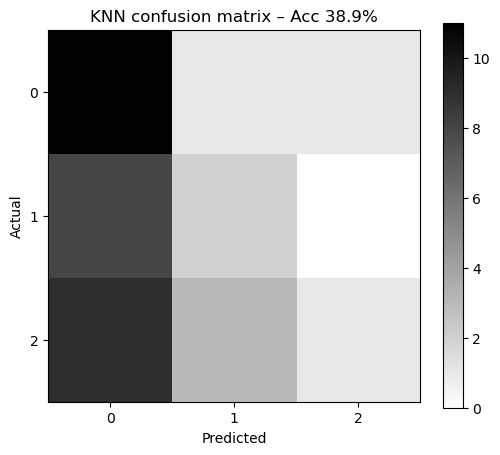

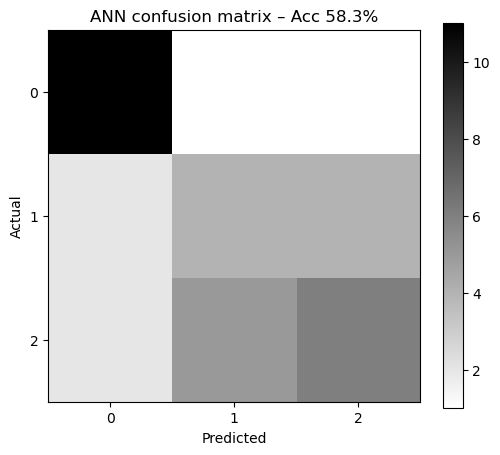

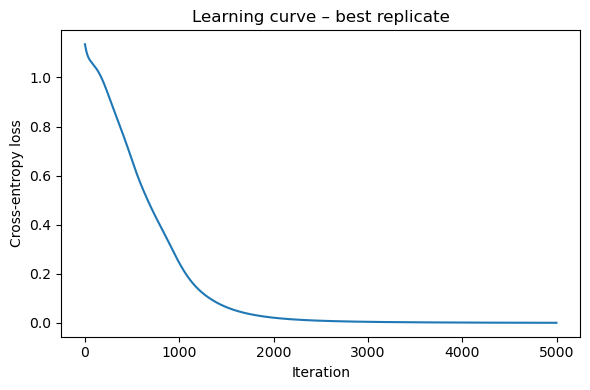

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_validate
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from dtuimldmtools import train_neural_net
import seaborn as sns 


df = pd.read_csv("HR_data.csv")

hr_feats = ["HR_Mean", "HR_Median", "HR_std",
            "HR_Min", "HR_Max", "HR_AUC"]
target   = "Frustrated"

df["frust_cls"] = pd.qcut(df[target], q=3, labels=[0, 1, 2]).astype(int)
df["Puzzler"]   = df["Puzzler"].map({"puzzler": 1, "instructor": 0})
df.dropna(subset=hr_feats + ["frust_cls", "Individual"], inplace=True)

X      = df[hr_feats].values
y      = df["frust_cls"].values
groups = df["Individual"].values
macroF1 = make_scorer(f1_score, average="macro")
labels = [0, 1, 2]


gkf = GroupKFold(n_splits=5)
train_idx, test_idx = next(gkf.split(X, y, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

scaler      = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# K-nearest neighbours
knn = KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
knn.fit(X_train_std, y_train)
y_pred_knn = knn.predict(X_test_std)

cm_knn  = confusion_matrix(y_test, y_pred_knn)
acc_knn = 100 * cm_knn.diagonal().sum() / cm_knn.sum()

plt.figure(1, figsize=(6, 5))
plt.imshow(cm_knn, cmap="binary")
plt.colorbar()
plt.xticks(labels); plt.yticks(labels)
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title(f"KNN confusion matrix – Acc {acc_knn:.1f}%")

print(f"\nKNN results  (Acc: {acc_knn:.2f}%)")
print(classification_report(y_test, y_pred_knn, digits=3))

f1m_knn = f1_score(y_test, y_pred_knn, average="macro")
print(f"Macro-F1:    {f1m_knn:.3f}")

# Feed-forward ANN

n_hidden_units = 16
max_iter       = 5000


class_counts  = np.bincount(y_train, minlength=len(labels))
class_w       = torch.tensor(1.0 / class_counts, dtype=torch.float32)
loss_fn       = torch.nn.CrossEntropyLoss(weight=class_w)

M, C = X_train_std.shape[1], len(labels)
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hidden_units, n_hidden_units),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hidden_units, C)
)

to_t = lambda x: torch.tensor(x, dtype=torch.float32)
net, best_loss, learning_curve = train_neural_net(
    model, loss_fn,
    X=to_t(X_train_std), y=torch.tensor(y_train, dtype=torch.long),
    n_replicates=10, max_iter=max_iter)

print(f"\nANN finished – best replicate loss: {best_loss:.4f}")

y_pred_ann = torch.argmax(net(to_t(X_test_std)), dim=1).numpy()

cm_ann  = confusion_matrix(y_test, y_pred_ann)
acc_ann = 100 * cm_ann.diagonal().sum() / cm_ann.sum()

plt.figure(2, figsize=(6,5))
plt.imshow(cm_ann, cmap="binary")
plt.colorbar()
plt.xticks(labels); plt.yticks(labels)
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title(f"ANN confusion matrix – Acc {acc_ann:.1f}%")

plt.figure(3, figsize=(6,4))
plt.plot(learning_curve)
plt.xlabel("Iteration"); plt.ylabel("Cross-entropy loss")
plt.title("Learning curve – best replicate")

print("\nANN results")
print(classification_report(y_test, y_pred_ann, digits=3))

f1m_ann = f1_score(y_test, y_pred_ann, average="macro")
print(f"Macro-F1:    {f1m_ann:.3f}")

plt.tight_layout()
plt.show()


In [40]:
pca_full = PCA().fit(X_train_std)          # six HR columns, all standardised
print(np.cumsum(pca_full.explained_variance_ratio_))

[0.59002795 0.86856924 0.96500078 0.9955732  0.99933988 1.        ]


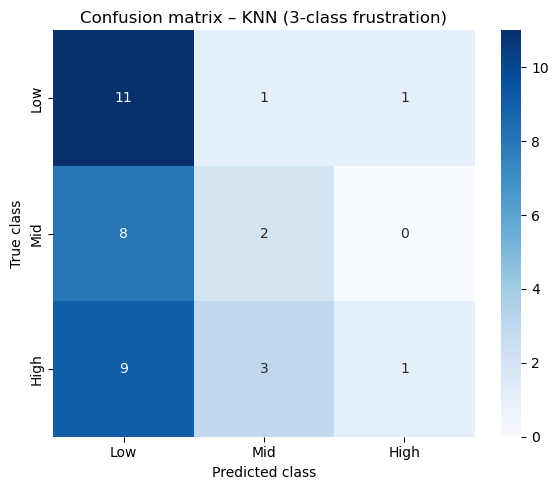

In [41]:
cls_names = ["Low", "Mid", "High"] 
cm = confusion_matrix(y_test, y_pred_knn, labels=[0, 1, 2])

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True, fmt="d",
            cmap="Blues", cbar=True,
            xticklabels=cls_names,
            yticklabels=cls_names)

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion matrix – KNN (3-class frustration)")
plt.tight_layout()
plt.show()



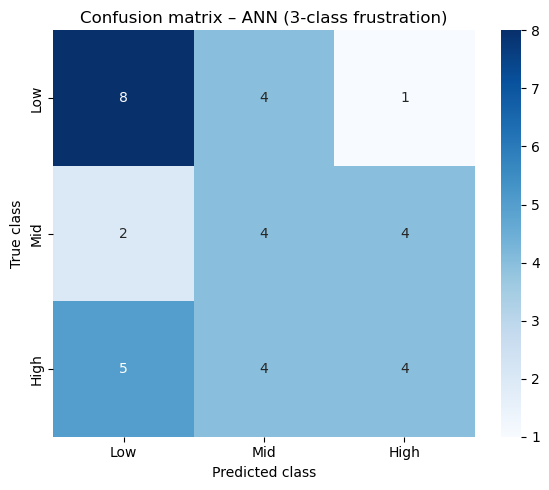

In [42]:
cls_names = ["Low", "Mid", "High"] 
cm = confusion_matrix(y_test, y_pred_ann, labels=[0, 1, 2])


plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True, fmt="d",
            cmap="Blues", cbar=True,
            xticklabels=cls_names,
            yticklabels=cls_names)

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion matrix – ANN (3-class frustration)")
plt.tight_layout()
plt.show()

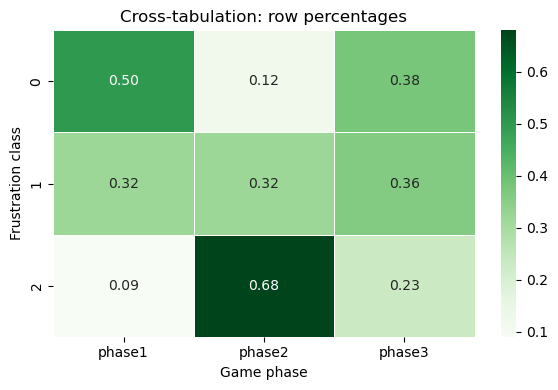

In [43]:
ct = pd.crosstab(df["frust_cls"], df["Phase"]) 

ct = ct.reindex(index=[0, 1, 2])

row_pct = ct.div(ct.sum(axis=1), axis=0).round(2)      # each row sums to 1

plt.figure(figsize=(6,4))
sns.heatmap(row_pct,
            annot=True, fmt=".2f", cmap="Greens", cbar=True,
            linewidths=.5, linecolor="white")
plt.xlabel("Game phase")
plt.ylabel("Frustration class")
plt.title("Cross-tabulation: row percentages")
plt.tight_layout()
plt.show()

In [57]:
# Task 2.2

In [ ]:
# Two-way Group-k-fold CV
#   – outer 5 folds: unbiased evaluation
#   – inner 3 folds: hyper-parameter tuning
import numpy as np, pandas as pd, torch
from sklearn.preprocessing  import StandardScaler
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.pipeline       import Pipeline
from sklearn.metrics        import make_scorer, f1_score
from sklearn.model_selection import GroupKFold, GridSearchCV
from dtuimldmtools          import train_neural_net
from sklearn.base import BaseEstimator, ClassifierMixin  

df = pd.read_csv("HR_data.csv")
hr_feats = ["HR_Mean","HR_Median","HR_std","HR_Min","HR_Max","HR_AUC"]
df["frust_cls"] = pd.qcut(df["Frustrated"], q=3, labels=[0,1,2]).astype(int)
df["Puzzler"]   = df["Puzzler"].map({"puzzler":1,"instructor":0})
df.dropna(subset=hr_feats+["frust_cls","Individual"], inplace=True)

X, y   = df[hr_feats].values, df["frust_cls"].astype(int).values
groups = df["Individual"].values
macroF1 = make_scorer(f1_score, average="macro")

# Inner grids
pipe_knn = Pipeline([("scaler", StandardScaler()),
                     ("knn",    KNeighborsClassifier())])

param_grid_knn = {"knn__n_neighbors":[3,5,7],
                  "knn__weights":["uniform","distance"]}

inner_cv = GroupKFold(n_splits=3)

def build_ann(n_hidden):
    return lambda: torch.nn.Sequential(
        torch.nn.Linear(len(hr_feats), n_hidden),
        torch.nn.Tanh(),
        torch.nn.Linear(n_hidden, n_hidden),
        torch.nn.Tanh(),
        torch.nn.Linear(n_hidden, 3)
    )

class ANNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden=16, max_iter=5000, random_state=None):
        self.n_hidden   = n_hidden
        self.max_iter   = max_iter
        self.random_state = random_state

    def fit(self, X, y):
        y = y.astype(int)
        cw = torch.tensor(1.0 / np.bincount(y, minlength=3),
                          dtype=torch.float32)
        loss_fn = torch.nn.CrossEntropyLoss(weight=cw)

        self.net_, _, _ = train_neural_net(
            build_ann(self.n_hidden), loss_fn,
            X=torch.tensor(X, dtype=torch.float32),
            y=torch.tensor(y, dtype=torch.long),
            n_replicates=1,
            max_iter=self.max_iter)        #  ←  verbose removed
        
        self.classes_ = np.array([0, 1, 2])
        return self

    def predict(self, X):
        X_t = torch.tensor(X, dtype=torch.float32)
        return torch.argmax(self.net_(X_t), dim=1).numpy()

pipe_ann = Pipeline([("scaler", StandardScaler()),
                     ("ann",    ANNWrapper())])

param_grid_ann = {"ann__n_hidden":[8,16,32]}

# Outer loop
outer_cv = GroupKFold(n_splits=5)
knn_outer_scores, ann_outer_scores = [], []

for train_idx, test_idx in outer_cv.split(X, y, groups):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    grp_tr     = groups[train_idx]

    # KNN
    gs_knn = GridSearchCV(pipe_knn, param_grid_knn,
                          cv=inner_cv,
                          scoring=macroF1, n_jobs=-1)
    gs_knn.fit(X_tr, y_tr, groups=grp_tr)
    y_pred_knn = gs_knn.predict(X_te)
    knn_outer_scores.append(f1_score(y_te, y_pred_knn, average="macro"))

    # ANN
    gs_ann = GridSearchCV(pipe_ann, param_grid_ann,
                          cv=inner_cv,
                          scoring=macroF1, n_jobs=-1)
    gs_ann.fit(X_tr, y_tr, groups=grp_tr)
    y_pred_ann = gs_ann.predict(X_te)
    ann_outer_scores.append(f1_score(y_te, y_pred_ann, average="macro"))

print(f"Two-way Group-k-fold CV – KNN macro-F1 : "
      f"{np.mean(knn_outer_scores):.3f} ± {np.std(knn_outer_scores):.3f}")
print(f"Two-way Group-k-fold CV – ANN macro-F1 : "
      f"{np.mean(ann_outer_scores):.3f} ± {np.std(ann_outer_scores):.3f}")



	Replicate: 1/1
		Iter	Loss			Rel. loss

	Replicate: 1/1
		Iter	Loss			Rel. loss

	Replicate: 1/1
		Iter	Loss			Rel. loss

	Replicate: 1/1
		Iter	Loss			Rel. loss

	Replicate: 1/1
		Iter	Loss			Rel. loss

	Replicate: 1/1
		Iter	Loss			Rel. loss

	Replicate: 1/1
		Iter	Loss			Rel. loss

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.4887819	0.001210182
		1000	0.4190531	0.0013563031
		1000	0.11194682	0.0028806815
		1000	0.17589	0.002494824
		1000	0.019803511	0.0036532956
		1000	0.015639441	0.0036498832
		1000	0.4727436	0.0013065846
		1000	0.10721931	0.0031071135
		2000	0.12717716	0.0009379908
		2000	0.12630431	0.001472086
		2000	0.011354497	0.0017056933
		2000	0.014745354	0.0020687622
		2000	0.0021332966	0.0014316268
		2000	0.0018605539	0.0013849488
		2000	0.1154704	0.0014203407
		2000	0.00945279	0.001593833
		3000	0.044220034	0.0012677853
		3000	0.034210343	0.0011199138
		3000	0.003163107	0.0011626134
		3000	0.0029976787	0.0010924808
		3000	0.000669589	0.00095827127
		3000	0.02545628

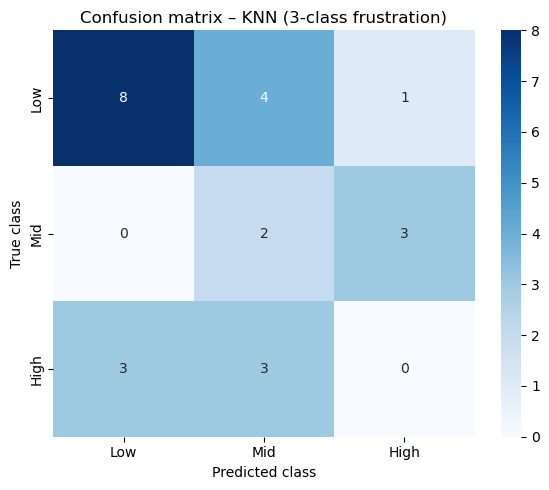

In [54]:
cls_names = ["Low", "Mid", "High"] 
cm = confusion_matrix(y_te, y_pred_knn, labels=[0, 1, 2])

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True, fmt="d",
            cmap="Blues", cbar=True,
            xticklabels=cls_names,
            yticklabels=cls_names)

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion matrix – KNN (3-class frustration)")
plt.tight_layout()
plt.show()

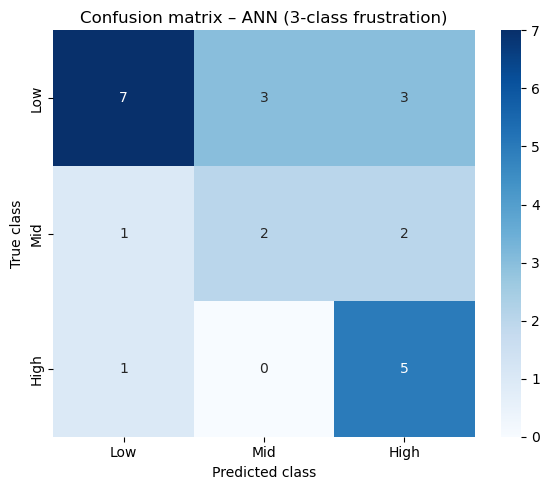

In [55]:
cls_names = ["Low", "Mid", "High"] 
cm = confusion_matrix(y_te, y_pred_ann, labels=[0, 1, 2])


plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True, fmt="d",
            cmap="Blues", cbar=True,
            xticklabels=cls_names,
            yticklabels=cls_names)

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion matrix – ANN (3-class frustration)")
plt.tight_layout()
plt.show()

In [59]:
# Task 2.3

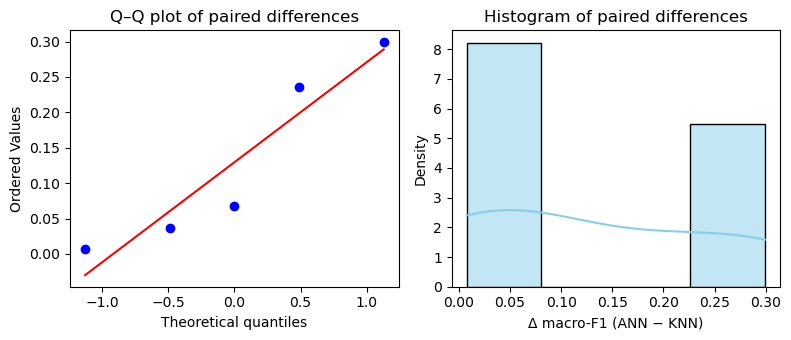

In [70]:
# Normality check: Q–Q plot and histogram + KDE
from scipy import stats

diff = np.array(ann_outer_scores) - np.array(knn_outer_scores)

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

# Q–Q plot of differences
stats.probplot(diff, dist="norm", plot=ax[0])
ax[0].set_title("Q–Q plot of paired differences")
ax[0].get_lines()[1].set_color("red")

# Histogram + KDE of differences
sns.histplot(diff, stat="density", kde=True,
             bins="auto", color="skyblue", edgecolor="black", ax=ax[1])
ax[1].set_title("Histogram of paired differences")
ax[1].set_xlabel("Δ macro-F1 (ANN − KNN)")

plt.tight_layout()
plt.show()


In [86]:
from scipy.stats import wilcoxon

w_stat, p_val = wilcoxon(diff, alternative="greater")   # ANN expected > KNN
print(f"Wilcoxon signed-rank  W={w_stat},  p={p_val:.4f}")

Wilcoxon signed-rank  W=15.0,  p=0.0312


In [83]:
y_true_all, y_pred_ann_all, y_pred_knn_all = [], [], []

outer_cv = GroupKFold(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y, groups), 1):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    grp_tr     = groups[train_idx]

    # KNN
    gs_knn = GridSearchCV(pipe_knn, param_grid_knn,
                          cv=inner_cv, scoring=macroF1, n_jobs=-1)
    gs_knn.fit(X_tr, y_tr, groups=grp_tr)
    y_pred_knn = gs_knn.predict(X_te)

    # ANN
    gs_ann = GridSearchCV(pipe_ann, param_grid_ann,
                          cv=inner_cv, scoring=macroF1, n_jobs=-1)
    gs_ann.fit(X_tr, y_tr, groups=grp_tr)
    y_pred_ann = gs_ann.predict(X_te)

    # sanity check
    if len(y_pred_knn) != len(y_te) or len(y_pred_ann) != len(y_te):
        print(f"Fold {fold}: size mismatch – KNN {len(y_pred_knn)}, "
              f"ANN {len(y_pred_ann)}, truth {len(y_te)}; skipping fold")
        continue          # skip this fold so lists stay aligned

    # aggregate
    y_true_all.extend(y_te)
    y_pred_knn_all.extend(y_pred_knn)
    y_pred_ann_all.extend(y_pred_ann)



	Replicate: 1/1
	Replicate: 1/1

	Replicate: 1/1


	Replicate: 1/1

	Replicate: 1/1

	Replicate: 1/1

	Replicate: 1/1

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Iter	Loss			Rel. loss
		Iter	Loss			Rel. loss
		Iter	Loss			Rel. loss
		Iter	Loss			Rel. loss
		Iter	Loss			Rel. loss
		Iter	Loss			Rel. loss
		Iter	Loss			Rel. loss
		1000	0.504728	0.00090577576
		1000	0.43270016	0.0010719945
		1000	0.48242807	0.001349889
		1000	0.088831276	0.0039859833
		1000	0.1351104	0.003247899
		1000	0.1031245	0.0032231275
		1000	0.023154764	0.003762282
		1000	0.010954899	0.0032459009
		2000	0.09746301	0.0013748091
		2000	0.16841727	0.0011216984
		2000	0.09849079	0.0016102075
		2000	0.007401431	0.0015599319
		2000	0.008859686	0.001795988
		2000	0.0014917237	0.0013504649
		2000	0.008763932	0.001712647
		2000	0.0023123205	0.0014511691
		3000	0.04933103	0.0012393438
		3000	0.033094082	0.00089792523
		3000	0.025047528	0.0011496152
		3000	0.002154546	0.0010171512
		3000	0.002224323	0.0011028924
		3000	0.00233

In [84]:
# Build McNemar table
y_true_all     = np.asarray(y_true_all)
y_pred_knn_all = np.asarray(y_pred_knn_all)
y_pred_ann_all = np.asarray(y_pred_ann_all)

assert len(y_true_all) == len(y_pred_knn_all) == len(y_pred_ann_all)

both_correct     = np.sum((y_pred_ann_all == y_true_all) &
                          (y_pred_knn_all == y_true_all))
ann_only_correct = np.sum((y_pred_ann_all == y_true_all) &
                          (y_pred_knn_all != y_true_all))
knn_only_correct = np.sum((y_pred_ann_all != y_true_all) &
                          (y_pred_knn_all == y_true_all))
both_wrong       = np.sum((y_pred_ann_all != y_true_all) &
                          (y_pred_knn_all != y_true_all))

table = [[both_correct, knn_only_correct],
         [ann_only_correct, both_wrong]]

from statsmodels.stats.contingency_tables import mcnemar
mcn = mcnemar(table, exact=True)     # exact p for small N
print(f"\nMcNemar’s test: χ²={mcn.statistic:.3f},  p={mcn.pvalue:.4f}")
print("Contingency table [ANN row / KNN col]:")
print(np.array(table))



McNemar’s test: χ²=17.000,  p=0.0595
Contingency table [ANN row / KNN col]:
[[42 17]
 [31 78]]


In [77]:
# Bootstrap 95 % CIs (2 000 replicates, percentile method)
rng        = np.random.default_rng(42)
n_boot     = 2000
ann_scores = np.array(ann_outer_scores)
knn_scores = np.array(knn_outer_scores)
diff       = ann_scores - knn_scores       # ANN improvement per fold

def boot_ci(arr):
    boot_means = [arr[rng.choice(len(arr), len(arr), replace=True)].mean()
                  for _ in range(n_boot)]
    return np.percentile(boot_means, [2.5, 97.5])

ci_ann  = boot_ci(ann_scores)
ci_knn  = boot_ci(knn_scores)
ci_diff = boot_ci(diff)

print("\nBootstrap 95 % CIs (2 000 replicates)")
print(f"  KNN  mean macro-F1 = {knn_scores.mean():.3f} "
      f"[{ci_knn[0]:.3f}, {ci_knn[1]:.3f}]")
print(f"  ANN  mean macro-F1 = {ann_scores.mean():.3f} "
      f"[{ci_ann[0]:.3f}, {ci_ann[1]:.3f}]")
print(f"  Δ    mean (ANN−KNN)= {diff.mean():.3f} "
      f"[{ci_diff[0]:.3f}, {ci_diff[1]:.3f}]")



Bootstrap 95 % CIs (2 000 replicates)
  KNN  mean macro-F1 = 0.307 [0.253, 0.352]
  ANN  mean macro-F1 = 0.437 [0.364, 0.503]
  Δ    mean (ANN−KNN)= 0.130 [0.031, 0.234]
